/home/dronelab/delaunay_rasterization
24.964031, 16.646481, 0.720127
22.077137, 15.425084, 0.870392
8.332846, 18.591625, 0.870392
9.599707, 15.331438, 0.870392
2.083211, 3.832860, 0.180032 - 6.241008, 4.647906, 0.217598


ic| screen_space: tensor([[24.9640312195, 22.0771369934,  8.3328437805,  9.5997056961],
                          [16.6464805603, 15.4250850677, 18.5916271210, 15.3314380646],
                          [ 1.0000000000,  1.0000000000,  1.0000000000,  1.0000000000]])
ic| screen_space / tile_size: tensor([[6.2410078049, 5.5192842484, 2.0832109451, 2.3999264240],
                                      [4.1616201401, 3.8562712669, 4.6479067802, 3.8328595161],
                                      [0.2500000000, 0.2500000000, 0.2500000000, 0.2500000000]])


2 6
3 5
tensor([2, 3, 7, 5], device='cuda:0', dtype=torch.int32)


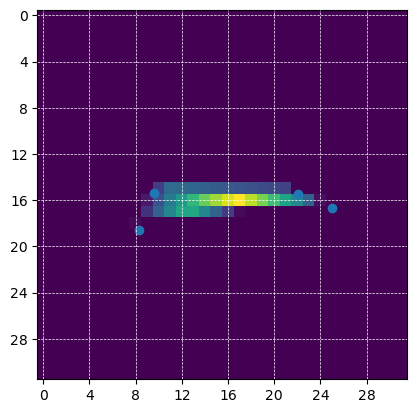

In [25]:
import os
VERSION = 9
if VERSION is not None:
    os.environ["CC"] = f"/usr/bin/gcc-{VERSION}"
    os.environ["CXX"] = f"/usr/bin/g++-{VERSION}"
from pathlib import Path
import sys
sys.path.append(str(Path(os.path.abspath('')).parent))
print(str(Path(os.path.abspath('')).parent))
from absl.testing import absltest
from absl.testing import parameterized
import torch
from pyquaternion import Quaternion
import numpy as np
from utils.compare_quad import test_tetrahedra_rendering
from utils.test_util import compare_dict_values, bcolors
import random
import math
from icecream import ic
import matplotlib.pyplot as plt

torch.manual_seed(189710234)
radius = 0.2
offset_mag = 1.2
height = 32
width = 32
tile_size = 4

indices = torch.tensor([[0, 1, 2, 3]]).int().cuda()
vertices = (torch.rand((4, 3)).cuda() * 2 - 1) * radius

# Select random face
face_idx = torch.randint(0, 4, (1,)).item()
face_verts = [[1,2,3], [0,2,3], [0,1,3], [0,1,2]][face_idx]

# Generate point on face
face_barycentric = torch.rand(3).cuda()
face_barycentric = face_barycentric / face_barycentric.sum()
face_vertices = vertices[indices[0][face_verts]]
face_point = face_vertices.T @ face_barycentric

# Calculate normal and offset
edge1 = face_vertices[1] - face_vertices[0]
edge2 = face_vertices[2] - face_vertices[0]
normal = torch.cross(edge1, edge2)
normal = normal / torch.norm(normal)

# Position camera
offset = (random.random()*2-1) * offset_mag
camera_pos = face_point + normal * offset

# Create view matrix looking at face point
forward = face_point - camera_pos
forward = forward / torch.norm(forward)
right = torch.cross(forward, torch.randn(3).cuda())
right = right / torch.norm(right)
up = torch.cross(right, forward)


fov_degrees = 90
f = height / math.tan(fov_degrees * math.pi / 180 / 2.0)
K = torch.tensor([
    [f, 0, width/2],
    [0, f, height/2],
    [0, 0, 1],
]).cuda()

viewmat = torch.eye(4).cuda()
viewmat[:3, 0] = right
viewmat[:3, 1] = up
viewmat[:3, 2] = forward
viewmat[:3, 3] = camera_pos
viewmat = torch.linalg.inv(viewmat)
rgbs = torch.ones(1, 4).cuda()
rgbs[:, 3] = 10
results = test_tetrahedra_rendering(vertices, indices, rgbs, viewmat, 
                            height=height, width=width, tile_size=tile_size, n_samples=10000)

homo = torch.cat([vertices, torch.ones_like(vertices[:, 0:1])], dim=1)
cam_space = (viewmat @ homo.T).T
screen_space = K @ (cam_space / cam_space[:, 2:3].abs())[:, :3].T
screen_space = screen_space.cpu()
ic(screen_space)
ic(screen_space / tile_size)
im = results['torch_image']
rt = results['rect_tile_space'][0]
im = im.sum(axis=-1)
him = np.where(im.sum(axis=0) > 0)
wim = np.where(im.sum(axis=1) > 0)
tminx = math.floor(np.min(him) / tile_size)
tmaxx = math.ceil(np.max(him) / tile_size)
tminy = math.floor(np.min(wim) / tile_size)
tmaxy = math.ceil(np.max(wim) / tile_size)
print(tminx, tmaxx)
print(tminy, tmaxy)
print(rt)
fig, ax = plt.subplots()
ax.imshow(im*10)
# Set grid lines every 4 units
ax.set_xticks(np.arange(0, im.shape[1], 4))
ax.set_yticks(np.arange(0, im.shape[0], 4)[::-1])
ax.grid(which='both', color='white', linestyle='--', linewidth=0.5)

ax.scatter(screen_space[0, :], screen_space[1, :])

# Ensure grid lines are drawn over the image
ax.set_axisbelow(False)
fig.show()